In [ ]:
import subprocess
import calendar
import pickle
import numpy as np

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# if there are missing that needs to be back filled

from pathlib import Path
import pandas as pd
import re

def check_missing(folder):
    dates = [
        pd.to_datetime(m.group(1), format="%Y%m%d")
        for f in Path(folder).glob("*.nc")
        if (m := re.match(r"^(\d{8})\.nc$", f.name))
    ]

    if not dates:
        return []

    found = pd.DatetimeIndex(dates)
    expected = pd.date_range("2016-01-01", found.max(), freq="D")
    missing = expected.difference(found)

    return [(d.year, d.month, d.day) for d in missing]

missing = check_missing("/home/chm003/project/hrdps/all")
date_split = np.array_split(missing, 1)
date_split

In [ ]:
# other wise backfill it all
dates = []
max_jobs = 32*10
for year in range(2016,2024):
    for month in range(1,13): # 1,1
        _, num_days = calendar.monthrange(year, month)
        for day in range(1,num_days + 1): # +1 for the range bound of [ )
            # print(f'{year}-{month}-{day}')
            dates.append((year, month, day))

date_split = np.array_split(dates, max_jobs)

date_split = [arr for arr in date_split if arr.size > 0]


In [ ]:
for chunk in range(len(date_split)):
    with open(f"chunk_{chunk}.pkl", 'wb') as f:
        pickle.dump(date_split[chunk], f)


    job = fr"""
#!/bin/bash
#PBS -S /bin/bash
#PBS -j oe
#PBS -m abe
#PBS -q development
#PBS -l walltime=06:00:00
#PBS -l select=1:ncpus=1:mem=64gb

. ssmuse-sh -p /fs/ssm/eccc/cmd/cmds/env/python/cmds_python_latest

cd ~/project/hrdps
python eccc-extract-hrdps/main.py --file chunk_{chunk}.pkl
rm chunk_{chunk}.pkl
"""
    
    # print(f'submit {chunk}')
    subprocess.run(['/opt/pbs/bin/qsub'], input=job, text=True)



In [22]:
import xarray as xr

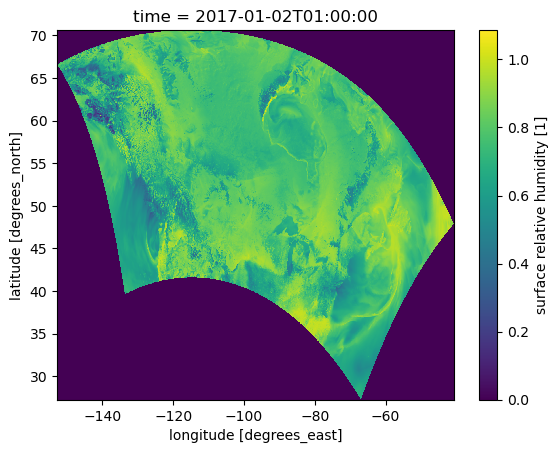

In [23]:
ds = xr.open_mfdataset('all/20170102.nc')
ds.isel(time=1).RH.plot()